# **CVPS20 // Sliding Window Object Detector**

*December 3, 2020*

This notebook introduces the concept of a sliding window detector, using a CNN as the feature extractor and classifier for each window.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

Let's load in the scanning probe microscope data that we used in the last assignment,

In [ ]:
# -- load data
data = np.load("/content/drive/MyDrive/cvps20/data/spm/train_good_all.npy")

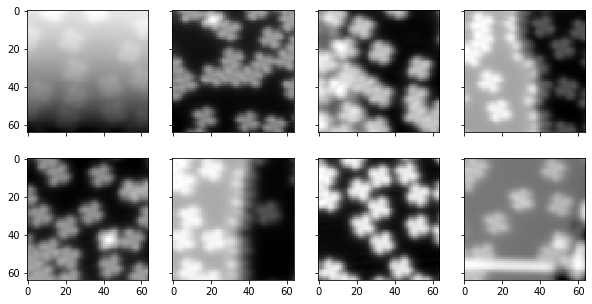

In [ ]:
# -- visualize some examples
fig, ax = plt.subplots(2, 4, figsize=[10, 5], sharex=True, sharey=True)
for ii in range(8):
  ax[ii // 4, ii % 4].imshow(data[ii])
fig.show()

Our goal will be to build an **object detector** to find those magnesium phthalocyanine (MgPc) molecules in a given image.

First we normalize the images,

In [ ]:
# -- normalize
norm = (data - data.min(axis=(1, 2), keepdims=True)) / (data.max(axis=(1, 2), keepdims=True) - data.min(axis=(1, 2), keepdims=True))

In [ ]:
norm[30].max()

1.0

Now we load the pre-labeled MgPc positive and negative locations,

In [ ]:
# -- load the pos and neg locations
pos = np.load("/content/drive/MyDrive/cvps20/data/spm/spm_struct_pos.npy")
neg = np.load("/content/drive/MyDrive/cvps20/data/spm/spm_struct_neg.npy")

In [ ]:
pos

array([[  30,   25,   51],
       [  32,   33, 1136],
       [  16,   52,  186],
       ...,
       [  25,   23,  407],
       [  31,   35, 1184],
       [  39,   32,  982]])

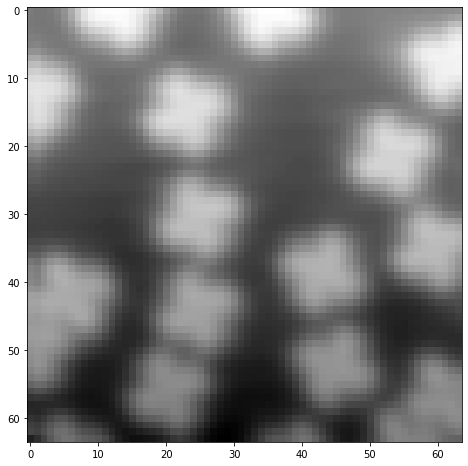

In [ ]:
plt.imshow(norm[51])

Using these locations, we can create postage stamps of examples of MgPc molecules and background,

In [ ]:
# -- create pos postage stamps
wid = 10
stmp_pos = []
for ii in range(pos.shape[0]):
  trow, tcol, tind = pos[ii]

  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_pos.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])

stmp_pos = np.array(stmp_pos)

In [ ]:
# -- create neg postage stamps
stmp_neg = []
for ii in range(neg.shape[0]):
  trow, tcol, tind = neg[ii]

  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_neg.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])

stmp_neg = np.array(stmp_neg)

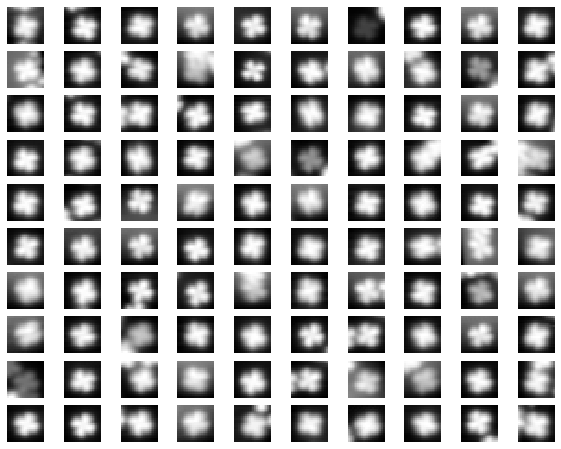

In [ ]:
# -- plot some positive examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
  ax[ii // 10, ii % 10].imshow(stmp_pos[ii])
  ax[ii // 10, ii % 10].axis("off")
fig.show()

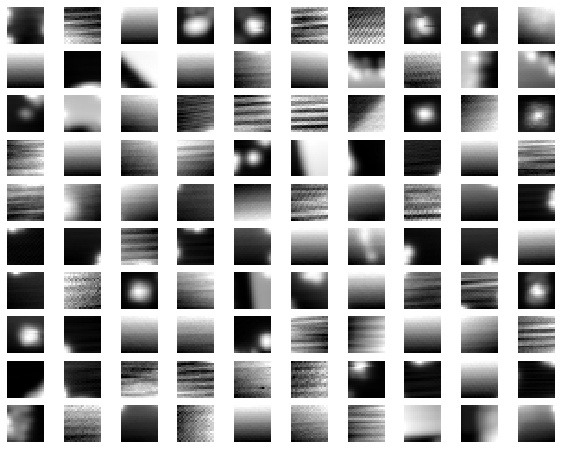

In [ ]:
# -- plot some negative examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
  ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
  ax[ii // 10, ii % 10].axis("off")
fig.show()

Now we build a classifier that, for a given proposal location, would classify a positive or negative MgPc detection,

In [ ]:
# -- create a training/testing set
feat = np.concatenate((stmp_neg, stmp_pos), axis=0)
targ = np.concatenate((np.full(stmp_neg.shape[0], 0), np.full(stmp_pos.shape[0], 1)))

feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ, random_state=302)

feat_tr = feat_tr.reshape(feat_tr.shape[0], feat_tr.shape[1], feat_tr.shape[2], 1)
feat_te = feat_te.reshape(feat_te.shape[0], feat_te.shape[1], feat_te.shape[2], 1)

Epoch 1/50
12/12 [==============================] - 0s 20ms/step - loss: 0.7452 - accuracy: 0.6553 - val_loss: 0.6129 - val_accuracy: 0.9394
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5628 - accuracy: 0.9168 - val_loss: 0.4159 - val_accuracy: 0.9242
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.4031 - accuracy: 0.9202 - val_loss: 0.3465 - val_accuracy: 0.8788
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.3262 - accuracy: 0.8998 - val_loss: 0.2963 - val_accuracy: 0.9091
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.3013 - accuracy: 0.9253 - val_loss: 0.2606 - val_accuracy: 0.9242
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2565 - accuracy: 0.9491 - val_loss: 0.2994 - val_accuracy: 0.9091
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2231 - accuracy: 0.9525 - val_loss: 0.2542 - val_accuracy: 0.9242
Epoch 8/50
12/12 [=

Text(0.5, 0, 'epoch')

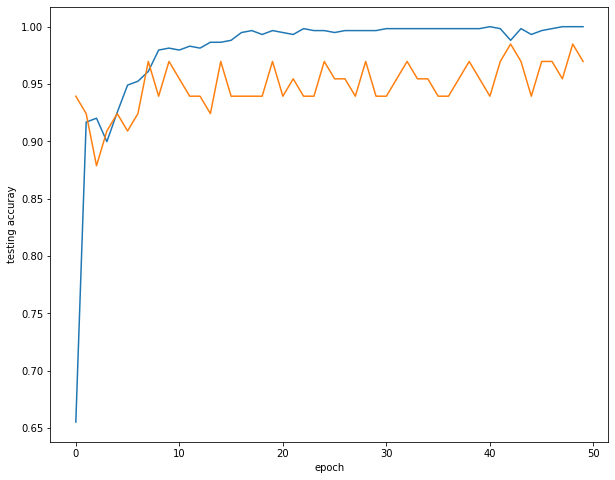

In [ ]:
# -- build a simple CNN
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", activation="relu", input_shape=(2 * wid, 2 * wid, 1), kernel_regularizer=keras.regularizers.l2(0.001))
layer2 = keras.layers.MaxPool2D(2)
layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))
layer4 = keras.layers.MaxPool2D(2)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(64, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001))
layer7 = keras.layers.Dense(2, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate the model
model = keras.Sequential(layers)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- fit the model
history = model.fit(feat_tr, targ_tr, epochs=50, validation_split=0.1, batch_size=50)

# -- print the accuracy
loss_tr, acc_tr = model.evaluate(feat_tr, targ_tr)
loss_te, acc_te = model.evaluate(feat_te, targ_te)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

# -- plot the accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("testing accuray")
plt.xlabel("epoch")

Now let's apply this classifier to one of the images,

(-0.5, 43.5, 43.5, -0.5)

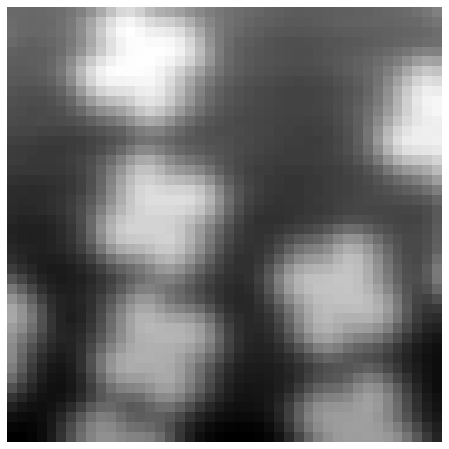

In [ ]:
# -- visualize one of the images
img = norm[51].copy()

plt.imshow(img[wid:64-wid, wid:64-wid])
plt.axis("off")

In [ ]:
# -- create ALL the postage stamps
nrow, ncol = img.shape
stamps = []
for ii in range(wid, nrow - wid):
  for jj in range(wid, ncol - wid):
    stamps.append(img[ii-wid:ii+wid, jj-wid:jj+wid])
stamps = np.array(stamps)

In [ ]:
stamps.shape

(1936, 20, 20)

In [ ]:
# -- predict all of these
feat_stmp = np.expand_dims(stamps, axis=3)
pred = model.predict(feat_stmp)

In [ ]:
pred

array([[1.0000000e+00, 1.2427798e-10],
       [1.0000000e+00, 3.3688812e-11],
       [1.0000000e+00, 1.3927363e-11],
       ...,
       [1.0000000e+00, 5.5676658e-08],
       [9.9999988e-01, 6.0762382e-08],
       [9.9999964e-01, 4.0296422e-07]], dtype=float32)

In [ ]:
# -- create prediction image
pimg = np.zeros(img.shape)
pimg[wid:nrow-wid, wid:ncol-wid] = pred[:, 1].reshape(nrow - 2 * wid, ncol - 2 * wid)

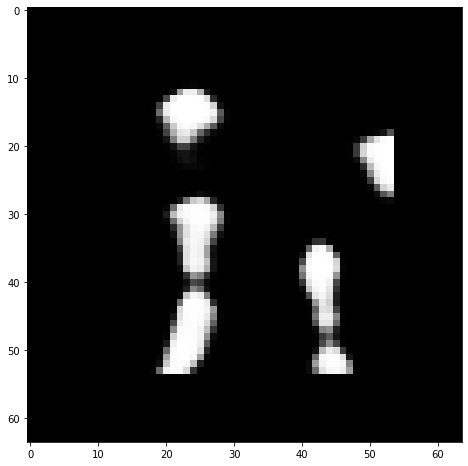

In [ ]:
# -- visualize
plt.imshow(pimg)

(10.0, 54.0)

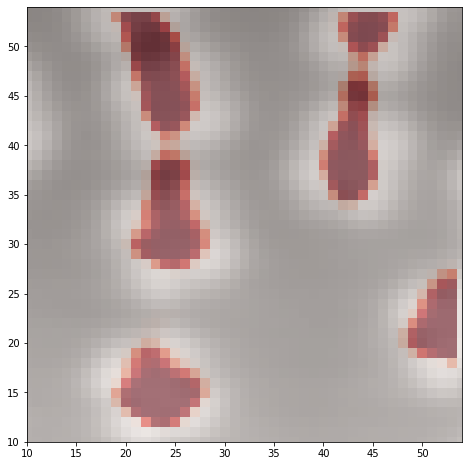

In [ ]:
plt.imshow(img)
plt.imshow(pimg, cmap="Reds", alpha=0.5)
plt.xlim(wid, ncol - wid)
plt.ylim(wid, nrow - wid)

(10.0, 54.0)

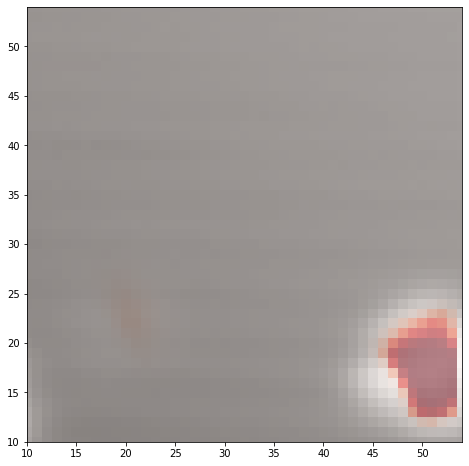

In [ ]:
# -- another example
img = norm[302].copy()

# -- create ALL the postage stamps
nrow, ncol = img.shape
stamps = []
for ii in range(wid, nrow - wid):
  for jj in range(wid, ncol - wid):
    stamps.append(img[ii-wid:ii+wid, jj-wid:jj+wid])
stamps = np.array(stamps)

# -- predict all of these
feat_stmp = np.expand_dims(stamps, axis=3)
pred = model.predict(feat_stmp)

# -- create prediction image
pimg = np.zeros(img.shape)
pimg[wid:nrow-wid, wid:ncol-wid] = pred[:, 1].reshape(nrow - 2 * wid, ncol - 2 * wid)

# -- visualize
plt.imshow(img)
plt.imshow(pimg, cmap="Reds", alpha=0.5)
plt.xlim(wid, ncol - wid)
plt.ylim(wid, nrow - wid)

Let's see an example of the "feature vector" that is ultimately used for classification.

In [ ]:
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])


In [ ]:
fvec = extractor(stmp_pos[0:1])


In [ ]:
fvec[5][0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([0.68620056, 1.144261  , 0.        , 0.        , 0.        ,
       0.60493505, 2.471081  , 0.        , 0.5621078 , 0.        ,
       0.        , 0.        , 0.        , 0.6114352 , 0.        ,
       2.295362  , 0.        , 1.0767093 , 0.30477425, 0.        ,
       0.        , 0.        , 0.45095435, 0.        , 0.5073186 ,
       0.        , 1.2097087 , 0.        , 0.        , 0.49515095,
       0.9117597 , 0.16378282, 0.5543732 , 0.        , 0.5179158 ,
       0.47016633, 0.        , 0.7518502 , 0.53049475, 0.87569773,
       0.6207049 , 0.        , 0.67724735, 0.85661685, 0.        ,
       1.8424445 , 0.45968375, 0.97731185, 0.        , 1.2443187 ,
       0.4361733 , 0.        , 0.5969511 , 0.        , 0.        ,
       0.7736596 , 1.3737315 , 1.7943895 , 1.5835353 , 0.        ,
       0.        , 1.0896311 , 0.        , 1.5461996 ], dtype=float32)>

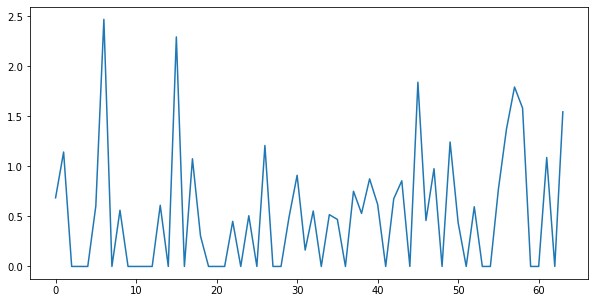

In [ ]:
# -- create the extraction model
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])

# -- get the feature vector for the various layers
fvec = extractor(stmp_pos[0:1])

# -- plot the output of the last dense layer
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(fvec[5][0])

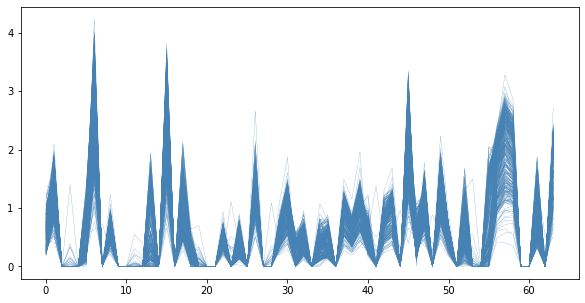

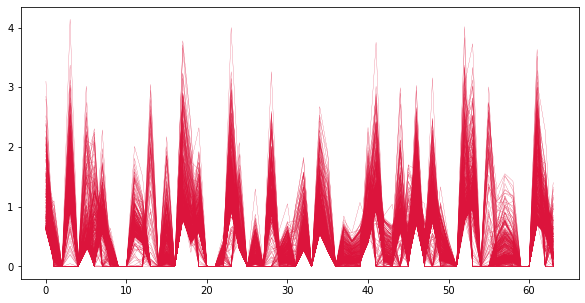

In [ ]:
# -- plot all positive example feature vectors
fvecs_pos = extractor(stmp_pos)
plt.figure(figsize=[10, 5])
dum = plt.plot(np.asarray(fvecs_pos[5]).T, color="steelblue", lw=0.2)

# -- plot all negative example feature vectors
fvecs_neg = extractor(stmp_neg)
plt.figure(figsize=[10, 5])
dum = plt.plot(np.asarray(fvecs_neg[5]).T, color="crimson", lw=0.2)
